# 1차 분류기

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from collections import defaultdict
df = pd.read_csv('./dataset/must_use_final.csv')  
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = df.sort_values("TIMESTAMP").reset_index(drop=True)
# 시점 정렬해서 5시간 시점만 추출하기 위해서
max_gap = pd.Timedelta(minutes=10) # 타겟 시점과 실제 데이터 시간의 최대 허용 오차를 10분으로 제한함
time_offsets = [17]  # 선박별로 출항 시점 기준으로 3,5,9 시간 뒤의 위치 데이터를 추출 -> 여기 수정해서 사용 ✅
time_based_data = {hour: [] for hour in time_offsets}  # 각 시간마다 추출된 데이터를 담을 빈 리스트로 시작함

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]): # 선박과 도착항구의 조합별로 데이터 나눠서 봄
    group = group.sort_values("TIMESTAMP")   # 해당 선박의 데이터를 시간순 정렬
    if group.empty:   # 비어있으면 contimue로 패스
        continue
    start_time = group["TIMESTAMP"].min()   # 출발 시점을 start time 설정
    for hour in time_offsets:
        target_time = start_time + pd.Timedelta(hours=hour)
        time_diff = (group["TIMESTAMP"] - target_time).abs()  # .abs() 절대값
        closest_idx = time_diff.idxmin()    # idxmin(): 가장 작은 차이를 가진 인덱스 추출
        if time_diff[closest_idx] <= max_gap: # max_gap 10 분 보다 시간 차이 크면 무시
            closest_row = group.loc[closest_idx]    # 조건 통과시 row 뽑아서 저장
            time_based_data[hour].append(closest_row) # time_based_data[hour] 여기에 추가
df_5h = pd.DataFrame(time_based_data[17]).reset_index(drop=True)  # 5시간 뒤 시의 데이터만 모음

feature_cols = ['LAT', 'LON', 'COG', 'HEADING']  # 독립 변수
target_col = 'CLUSTER_1'     # 종속변수
X = df_5h[feature_cols].values   # 값만 뽑아내기
y = df_5h[target_col].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42       # stratify=y : 클래스 비율 유지하면서 train/test 분할
)  

# ===== RandomForest 하이퍼파라미터 튜닝 =====
param_grid_rf = {      # 여기서 정의한 값들을 조합해 최적 성능을 내는 조합을 찾는 과정
    'n_estimators': [100, 200],   # 트리 몇 개 만들지 (많을수록 성능 안정)
    'max_depth': [8, 10],       # 각 트리의 최대 깊이 (적절한 깊이가 중요)
    'min_samples_split': [2, 5],   # 노드 분할하기 위해 필요한 최소 샘플 수
    'max_features': ['sqrt', 'log2']   # 각 트리 노드를 분할할 때 몇 개 특성을 고려할지 / 'sqrt': 전체 특성 수의 제곱근 / 'log2': 전체 특성 수의 로그2
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid_rf,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("✅ 최적 RF 파라미터:", grid_rf.best_params_)

# ===== XGBoost 하이퍼파라미터 튜닝 =====
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("✅ 최적 XGB 파라미터:", grid_xgb.best_params_)

# ===== KNN 하이퍼파라미터 튜닝 =====
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
print("✅ 최적 KNN 파라미터:", grid_knn.best_params_)

# ===== 최적 모델로 소프트 보팅 앙상블 구성 =====
classifier = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('knn', best_knn),
    ('xgb', best_xgb)
], voting='soft')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 전체 모델 정확도: {accuracy:.4f}")

class_accuracy = defaultdict(list)
for true_label, pred_label in zip(y_test, y_pred):
    class_accuracy[true_label].append(true_label == pred_label)

print("\n📌 클래스별 정확도 (CLUSTER_1 오름차순):")
for cls in sorted(class_accuracy.keys()):
    acc = np.mean(class_accuracy[cls])
    print(f" - {cls}: {acc:.4f}")

# ===== 정밀도, 재현율, F1-score 출력 =====
print("\n📊 분류 성능 보고서 (classification report):")
print(classification_report(y_test, y_pred, digits=4))

# ===== 교차검증 + macro F1-score 평가 =====
print("\n🔁 [교차검증] 5-Fold 예측 수행 중...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(classifier, X, y, cv=skf)
acc_cv = accuracy_score(y, y_pred_cv)
macro_f1 = f1_score(y, y_pred_cv, average='macro')
weighted_f1 = f1_score(y, y_pred_cv, average='weighted')

print(f"\n✅ [교차검증] 전체 정확도: {acc_cv:.4f}")
print(f"🌍 [교차검증] macro F1-score: {macro_f1:.4f}")
print(f"⚖️ [교차검증] weighted F1-score: {weighted_f1:.4f}\n")

print("📊 [교차검증] classification report:")
print(classification_report(y, y_pred_cv, digits=4))

print("\n📌 [교차검증] CLUSTER_1별 정확도:")
class_accuracy_cv = defaultdict(list)
for true_label, pred_label in zip(y, y_pred_cv):
    class_accuracy_cv[true_label].append(true_label == pred_label)

for cls in sorted(class_accuracy_cv):
    acc = np.mean(class_accuracy_cv[cls])
    print(f" - CLUSTER_1 = {cls}: 정확도 {acc:.4f} ({len(class_accuracy_cv[cls])}개 샘플)")

import joblib
import os

# 모델 저장
joblib.dump(classifier, 'model/cluster_17hours.joblib')

# 인코더 저장
# joblib.dump(le, 'model/encoder_2.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")


✅ 최적 RF 파라미터: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
✅ 최적 XGB 파라미터: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
✅ 최적 KNN 파라미터: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

🎯 전체 모델 정확도: 0.8487

📌 클래스별 정확도 (CLUSTER_1 오름차순):
 - 0: 0.0000
 - 1: 0.8000
 - 2: 0.7778
 - 3: 0.9643
 - 4: 0.9000
 - 5: 0.0000
 - 6: 0.9412
 - 7: 1.0000

📊 분류 성능 보고서 (classification report):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.8000    0.8000    0.8000        25
           2     0.9545    0.7778    0.8571        27
           3     0.9643    0.9643    0.9643        28
           4     0.6429    0.9000    0.7500        10
           5     0.0000    0.0000    0.0000         3
           6     0.7619    0.9412    0.8421        17
           7     1.0000    1.0000    1.0000         8

    accuracy                         0.8487       119
   mac

# 1번군집

✅ 학습 및 테스트 데이터셋 저장 완료!

📘 [Train Set]
Accuracy: 0.975
F1-score: 0.9749

📙 [Test Set]
Accuracy: 0.625
F1-score: 0.6425

📊 [교차검증 결과]
Train Accuracy : 0.9750
Test Accuracy  : 0.6250
Accuracy Gap   : 0.3500 ⚠️ 과적합 의심
CV Accuracy    : 0.7833 ± 0.0612
CV F1 Macro    : 0.7744
CV Precision   : 0.7744

📄 [Classification Report - 항구명 기준]
              precision    recall  f1-score   support

       JPHIJ       1.00      0.50      0.67         2
       JPIMB       0.50      1.00      0.67         1
       KRINC       0.80      0.44      0.57         9
       KRKAN       0.75      0.75      0.75         4
       KRPTK       0.29      0.67      0.40         3
       KRYOS       0.80      0.80      0.80         5

    accuracy                           0.62        24
   macro avg       0.69      0.69      0.64        24
weighted avg       0.73      0.62      0.64        24



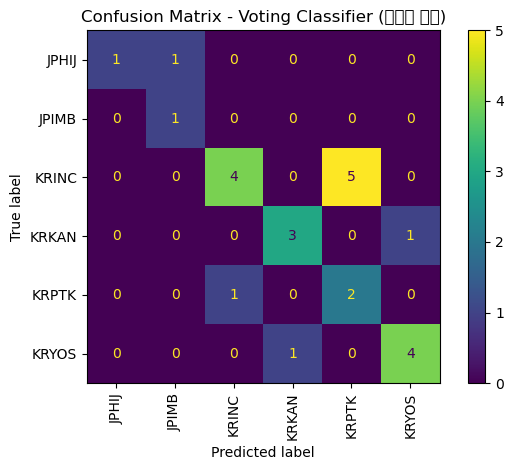

In [36]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, make_scorer,
    classification_report, ConfusionMatrixDisplay
)
from sklearn.utils import resample
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ===== 1. 데이터 불러오기 =====
df = pd.read_csv('./dataset/must_use_final.csv')
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
cluster_df = df[df['CLUSTER_1'] == 1].copy()

# ===== 2. 17시간 시점 데이터 추출 =====
max_gap = pd.Timedelta(minutes=10)
hour = 17
time_based_data = []

for (vsl_id, port), group in cluster_df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty:
        continue
    start_time = group["TIMESTAMP"].min()
    target_time = start_time + pd.Timedelta(hours=hour)
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin()
    if time_diff[closest_idx] <= max_gap:
        time_based_data.append(group.loc[closest_idx])

df_5h = pd.DataFrame(time_based_data).dropna(subset=["LAT", "LON", "COG", "HEADING", "PORT_NAME"])

# ===== 3. 라벨 인코딩 =====
le = LabelEncoder()
df_5h["PORT_NAME_STR"] = df_5h["PORT_NAME"].astype(str)
df_5h["label"] = le.fit_transform(df_5h["PORT_NAME_STR"])

# ===== 4. 클래스가 1개인 항구 제거 후 재라벨링 =====
label_counts = df_5h["label"].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df_5h = df_5h[df_5h['label'].isin(valid_labels)].reset_index(drop=True)

# 라벨 다시 인코딩
le = LabelEncoder()
df_5h["PORT_NAME_STR"] = df_5h["PORT_NAME"].astype(str)
df_5h["label"] = le.fit_transform(df_5h["PORT_NAME_STR"])

# ===== 5. 특징 및 학습/테스트 분할 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# ===== 6. 오버샘플링 =====
train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
train_df["PORT_NAME"] = le.inverse_transform(train_df["label"])

max_count = train_df['PORT_NAME'].value_counts().max()
oversampled_rows = []
for port_name in train_df['PORT_NAME'].unique():
    subset = train_df[train_df['PORT_NAME'] == port_name]
    if len(subset) < max_count:
        upsampled = resample(subset, replace=True, n_samples=max_count - len(subset), random_state=42)
        oversampled_rows.append(pd.concat([subset, upsampled]))
    else:
        oversampled_rows.append(subset)

df_train_oversampled = pd.concat(oversampled_rows).reset_index(drop=True)
X_bal = df_train_oversampled[features]
y_bal = le.transform(df_train_oversampled["PORT_NAME"])

# ===== 7. 스케일링 =====
scaler = StandardScaler()
X_bal_scaled = scaler.fit_transform(X_bal)
X_test_scaled = scaler.transform(X_test)

np.save("datasets/X_train_c1_17hours.npy", X_bal_scaled)
np.save("datasets/X_test_c1_17hours.npy", X_test_scaled)
np.save("datasets/y_train_c1_17hours.npy", y_bal)
np.save("datasets/y_test_c1_17hours.npy", y_test)
print("✅ 학습 및 테스트 데이터셋 저장 완료!")

# ===== 8. 모델 정의 및 학습 =====
lr = LogisticRegression(C=1.0, solver='liblinear', class_weight='balanced')
rf = RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_leaf=3, class_weight='balanced')

voting_clf = VotingClassifier(estimators=[
    ('lr', lr),
    ('rf', rf)
], voting='soft')

voting_clf.fit(X_bal_scaled, y_bal)

# ===== 9. 예측 및 평가 =====
y_train_pred = voting_clf.predict(X_bal_scaled)
y_test_pred = voting_clf.predict(X_test_scaled)

train_acc = accuracy_score(y_bal, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_bal, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print("\n📘 [Train Set]")
print("Accuracy:", round(train_acc, 4))
print("F1-score:", round(train_f1, 4))

print("\n📙 [Test Set]")
print("Accuracy:", round(test_acc, 4))
print("F1-score:", round(test_f1, 4))

# ===== 10. 교차검증 =====
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(voting_clf, X_bal_scaled, y_bal, cv=skf, scoring='accuracy')
cv_f1 = cross_val_score(voting_clf, X_bal_scaled, y_bal, cv=skf, scoring=make_scorer(f1_score, average='macro'))
cv_prec = cross_val_score(voting_clf, X_bal_scaled, y_bal, cv=skf, scoring=make_scorer(precision_score, average='macro'))

print("\n📊 [교차검증 결과]")
print(f"Train Accuracy : {train_acc:.4f}")
print(f"Test Accuracy  : {test_acc:.4f}")
print(f"Accuracy Gap   : {train_acc - test_acc:.4f} {'⚠️ 과적합 의심' if train_acc - test_acc > 0.1 else '✅ 과적합 위험 없음'}")
print(f"CV Accuracy    : {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
print(f"CV F1 Macro    : {cv_f1.mean():.4f}")
print(f"CV Precision   : {cv_prec.mean():.4f}")

# ===== 11. 라벨 복원 후 리포트 =====
y_test_decoded = le.inverse_transform(y_test)
y_test_pred_decoded = le.inverse_transform(y_test_pred)

print("\n📄 [Classification Report - 항구명 기준]")
print(classification_report(y_test_decoded, y_test_pred_decoded))

ConfusionMatrixDisplay.from_predictions(
    y_test_decoded, y_test_pred_decoded,
    display_labels=le.classes_,
    xticks_rotation=90
)
plt.title("Confusion Matrix - Voting Classifier (항구명 기준)")
plt.tight_layout()
plt.show()


In [39]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c1_17hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c1_17hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 2번 군집

✅ 학습 및 테스트 데이터셋 저장 완료!


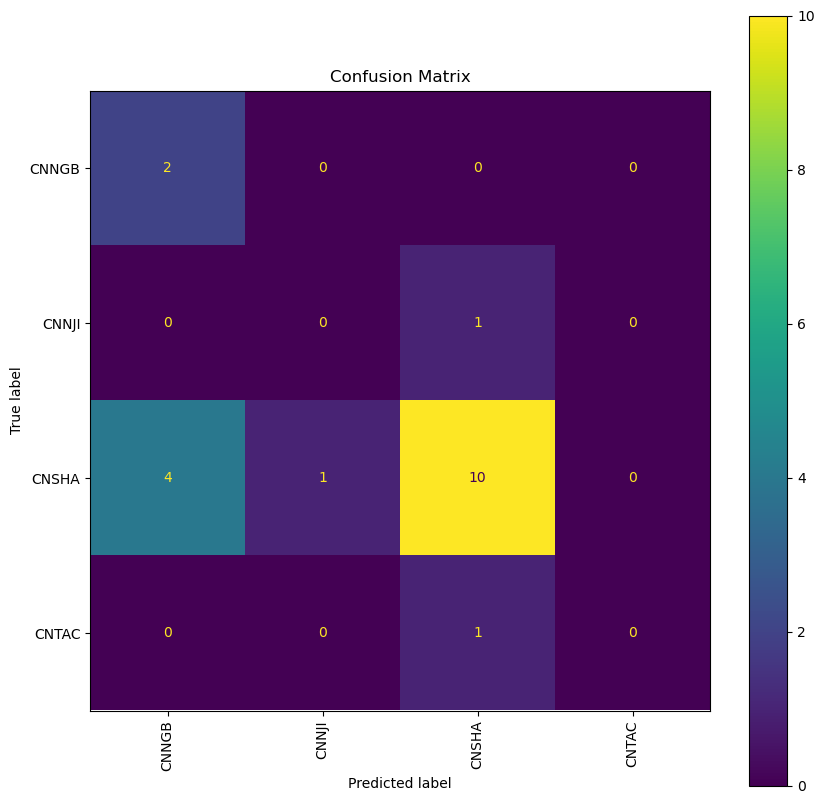


📊 [교차검증 및 과적합 점검 결과]
학습 정확도              : 0.9028
테스트 정확도            : 0.6316
정확도 차이              : 0.2712 ⚠️ 과적합 의심
교차검증 평균 정확도     : 0.7524 ± 0.0969
교차검증 F1 매크로 평균  : 0.3805
교차검증 정밀도 평균     : 0.3688

📄 [Classification Report]
              precision    recall  f1-score   support

       CNNGB       0.33      1.00      0.50         2
       CNNJI       0.00      0.00      0.00         1
       CNSHA       0.83      0.67      0.74        15
       CNTAC       0.00      0.00      0.00         1

    accuracy                           0.63        19
   macro avg       0.29      0.42      0.31        19
weighted avg       0.69      0.63      0.64        19



In [20]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import os

# ===== 1. 데이터 불러오기 및 CLUSTER_1 == 2 필터링 =====
df = pd.read_csv('./dataset/must_use_final.csv')
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = df[df["CLUSTER_1"] == 2].copy() # 여기 수정
df = df.sort_values("TIMESTAMP").reset_index(drop=True)

# ===== 2. 14시간 시점 기준 추출 =====
time_based_data = []
max_gap = pd.Timedelta(minutes=10)

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty: continue
    start_time = group["TIMESTAMP"].min()
    target_time = start_time + pd.Timedelta(hours=17) # 여기 수정
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin()
    if time_diff[closest_idx] <= max_gap:
        time_based_data.append(group.loc[closest_idx])

df_14h = pd.DataFrame(time_based_data).reset_index(drop=True)


# ===== 2. 피처 및 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_14h[features]         # ✅ 수정
y = df_14h["PORT_NAME"]      # ✅ 수정
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ===== 3. 학습/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# ===== 4. 클래스별 오버샘플링 (Train만) =====
class_counts = pd.Series(y_train).value_counts()
max_count = class_counts.max()
minority_classes = class_counts[class_counts < max_count * 1.5].index

# 원하는 샘플링 비율 지정
sampling_ratios = {
    0: 2.0,
    1: 2.5,
    2: 1.0,
    3: 2.5
}

resampled_X = []
resampled_y = []

for label in minority_classes:
    subset_X = X_train[y_train == label]
    subset_y = y_train[y_train == label]
    
    n_samples = int(len(subset_X) * sampling_ratios.get(label, 1.0))
    
    up_X = resample(subset_X, replace=True, n_samples=n_samples, random_state=42)
    up_y = np.full(n_samples, label)
    
    resampled_X.append(up_X)
    resampled_y.append(up_y)

X_train_resampled = np.vstack(resampled_X)
y_train_resampled = np.hstack(resampled_y)

# ===== 5. 모델 정의 및 학습 (하이퍼파라미터 조정 포함) =====
rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=50,
    max_depth=5,
    min_samples_leaf=5,
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.05,
    reg_alpha=0.5,
    reg_lambda=1.0,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft'
)

voting_clf.fit(X_train_resampled, y_train_resampled)

# ===== 6. 평가 =====
y_pred = voting_clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)

# ===== 7. 저장 =====

np.save("datasets/X_train_c2_17hours.npy", X_train_resampled)
np.save("datasets/X_test_c2_17hours.npy", X_test)
np.save("datasets/y_train_c2_17hours.npy", y_train_resampled)
np.save("datasets/y_test_c2_17hours.npy", y_test)
print("✅ 학습 및 테스트 데이터셋 저장 완료!")

# ===== 8. 교차검증 =====
acc_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy')
f1_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='f1_macro')
prec_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='precision_macro')

# ===== 9. 과적합 점검 =====
train_score = voting_clf.score(X_train, y_train)
test_score = voting_clf.score(X_test, y_test)
gap = train_score - test_score

# ===== 10. Confusion Matrix 시각화 =====
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ===== 11. 출력 =====
print("\n📊 [교차검증 및 과적합 점검 결과]")
print(f"학습 정확도              : {train_score:.4f}")
print(f"테스트 정확도            : {test_score:.4f}")
print(f"정확도 차이              : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '과적합 위험 없음'}")
print(f"교차검증 평균 정확도     : {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"교차검증 F1 매크로 평균  : {f1_scores.mean():.4f}")
print(f"교차검증 정밀도 평균     : {prec_scores.mean():.4f}")
print("\n📄 [Classification Report]")
print(report)


In [22]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c2_17hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c2_17hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 3번 군집

🔍 Classification Report (Label Number 기준):
              precision    recall  f1-score   support

           0       0.80      0.75      0.77        16
           1       0.69      0.75      0.72        12

    accuracy                           0.75        28
   macro avg       0.75      0.75      0.75        28
weighted avg       0.75      0.75      0.75        28

📊 Confusion Matrix:


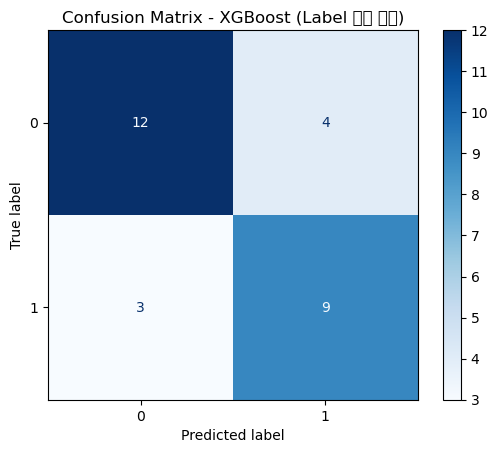


✅ 5-Fold 교차검증 정확도 평균: 0.7231 ± 0.1250

📈 Train Accuracy: 1.0000
📉 Test Accuracy : 0.7500
🔍 학습 정확도와 테스트 정확도의 차이: 0.25

📄 [Classification Report - 항구명 기준]
                                                       precision    recall  f1-score   support

              East Japan (JPKIJ, JPTYO, JPYOK, JPSMZ)       0.80      0.75      0.77        16
West Japan (JPUKB, JPOSA, JPWAK, JPYKK, JPNGO, JPMKX)       0.69      0.75      0.72        12

                                             accuracy                           0.75        28
                                            macro avg       0.75      0.75      0.75        28
                                         weighted avg       0.75      0.75      0.75        28



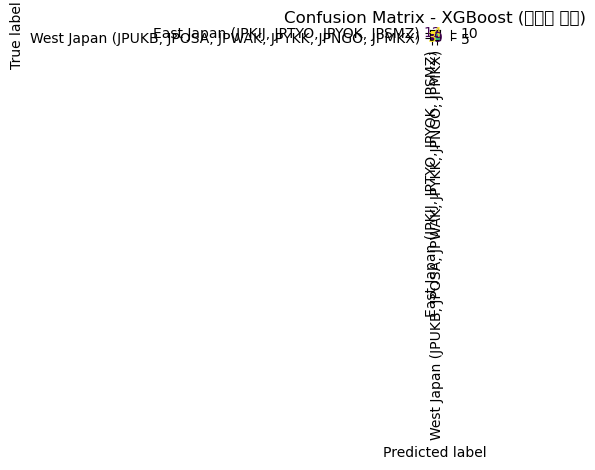

In [23]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ===== 1. 데이터 불러오기 =====
df = pd.read_csv('cluster_3_mapped_V2.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# ===== 2. 출발 5시간 시점 데이터 추출 =====
rows_5h = []
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    group = group.sort_values('TIMESTAMP')
    if len(group) >= 102:  # 10분 단위 30개 = 5시간
        row_5h = group.iloc[101]
        rows_5h.append(row_5h)

df_5h = pd.DataFrame(rows_5h).dropna(subset=["LAT", "LON", "COG", "HEADING"])

# ===== 3. 특성과 타겟 분리 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features].values
y_text = df_5h["PORT_CLUSTER"].astype(str).values  # 항구명 텍스트

# ===== 4. 라벨 인코딩 (split 전 먼저!) =====
le = LabelEncoder()
y = le.fit_transform(y_text)  # 전체 데이터 기준으로 인코딩

# ===== 5. 학습/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# ===== 6. 저장 =====
np.save("datasets/X_train_c3_17hours.npy", X_train)
np.save("datasets/X_test_c3_17hours.npy", X_test)
np.save("datasets/y_train_c3_17hours.npy", y_train)
np.save("datasets/y_test_c3_17hours.npy", y_test)

# ===== 7. 모델 정의 =====
model = XGBClassifier(
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# ===== 8. 모델 학습 =====
model.fit(X_train, y_train)

# ===== 9. 예측 및 평가 =====
y_pred = model.predict(X_test)

print("🔍 Classification Report (Label Number 기준):")
print(classification_report(y_test, y_pred))

print("📊 Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost (Label 번호 기준)")
plt.show()

# ===== 10. 교차검증 =====
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\n✅ 5-Fold 교차검증 정확도 평균: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# ===== 11. 과적합 여부 확인 =====
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)
print(f"\n📈 Train Accuracy: {train_acc:.4f}")
print(f"📉 Test Accuracy : {test_acc:.4f}")
print(f"🔍 학습 정확도와 테스트 정확도의 차이: {round(train_acc - test_acc, 4)}")

# ===== 12. 라벨 복원 =====
y_test_decoded = le.inverse_transform(y_test)
y_test_pred_decoded = le.inverse_transform(y_pred)

print("\n📄 [Classification Report - 항구명 기준]")
print(classification_report(y_test_decoded, y_test_pred_decoded))

ConfusionMatrixDisplay.from_predictions(
    y_test_decoded, y_test_pred_decoded,
    display_labels=le.classes_,
    xticks_rotation=90
)
plt.title("Confusion Matrix - XGBoost (항구명 기준)")
plt.tight_layout()
plt.show()


In [29]:
import joblib
import os

# 모델 저장
joblib.dump(model, 'model/port_c3_17hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c3_17hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 4번 군집

✅ Best XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 1.0, 'reg_lambda': 5.0, 'subsample': 1.0}
✅ Best LogisticRegression: {'C': 1.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}

📊 [앙상블 성능 평가 및 과적합 진단]
Train Accuracy           : 0.8140
Test Accuracy            : 0.5714
Accuracy Gap             : 0.2425 ⚠️ 과적합 의심
Train F1-score (macro)   : 0.7514
Test F1-score (macro)    : 0.4917
CV Accuracy Mean         : 0.5381 ± 0.1082
CV F1-score Mean         : 0.3583
CV Precision Mean        : 0.3250

📄 [Classification Report - 항구명 기준]
              precision    recall  f1-score   support

       CNHUA       0.00      0.00      0.00         2
       HKHKG       0.67      1.00      0.80         2
       TWKEL       1.00      0.50      0.67         2
       TWKHH       0.33      1.00      0.50         1

    accuracy                           0.57         7
   macro avg       0.50      0.62      0.49         7
weighted avg 

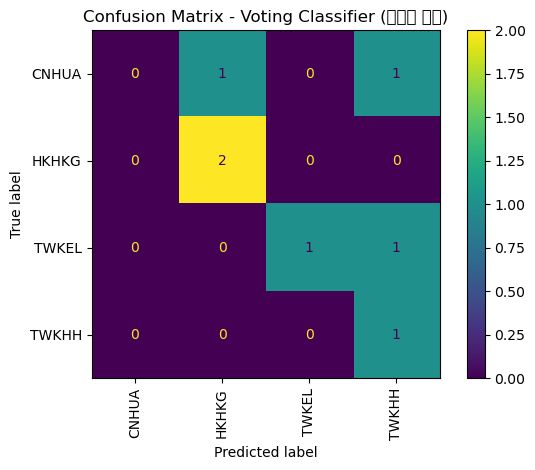

✅ 모델 저장 완료 (port_c4_17hours.joblib)


In [45]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    classification_report, make_scorer, ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import joblib
import os
import warnings
warnings.filterwarnings("ignore")

# ===== 1. 데이터 불러오기 및 CLUSTER_1 == 4 필터링 =====
df = pd.read_csv('./dataset/must_use_final.csv')
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = df[df["CLUSTER_1"] == 4].copy()
df = df.sort_values("TIMESTAMP").reset_index(drop=True)

# ===== 2. 17시간 시점 기준 추출 =====
time_based_data = []
max_gap = pd.Timedelta(minutes=10)
for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty:
        continue
    start_time = group["TIMESTAMP"].min()
    target_time = start_time + pd.Timedelta(hours=17)
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin()
    if time_diff[closest_idx] <= max_gap:
        time_based_data.append(group.loc[closest_idx])
df_17h = pd.DataFrame(time_based_data).reset_index(drop=True)

# ===== 3. 피처 및 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
df_17h = df_17h.dropna(subset=features + ["PORT_NAME"])
le = LabelEncoder()
df_17h["label"] = le.fit_transform(df_17h["PORT_NAME"])  # 숫자 라벨 저장

# ===== 💾 인코더 저장 =====
joblib.dump(le, "model/encoder_c4_17hours.joblib")

# ===== 4. 학습/테스트 분할 =====
X = df_17h[features]
y = df_17h["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ===== 5. 오버샘플링 (클래스별 비율 다르게) =====
train_df = pd.concat([X_train, y_train], axis=1)
custom_ratios = {
    0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5, 4: 3.0  # 필요에 따라 조정
}
oversampled_rows = []
for label in train_df["label"].unique():
    subset = train_df[train_df["label"] == label]
    ratio = custom_ratios.get(label, 1.0)
    n_samples = int(len(subset) * ratio)
    if ratio > 1.0:
        upsampled = resample(subset, replace=True, n_samples=n_samples - len(subset), random_state=42)
        oversampled_rows.append(pd.concat([subset, upsampled]))
    else:
        oversampled_rows.append(subset)
resampled_train = pd.concat(oversampled_rows).reset_index(drop=True)
X_train_raw = resampled_train[features]
y_train = resampled_train["label"]

# ===== 6. 스케일링 =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test)

# ===== 7. 저장 (스케일링 된 것 기준) =====
np.save("datasets/X_train_c4_17hours.npy", X_train_scaled)
np.save("datasets/X_test_c4_17hours.npy", X_test_scaled)
np.save("datasets/y_train_c4_17hours.npy", y_train)
np.save("datasets/y_test_c4_17hours.npy", y_test)

# ===== 8. 모델 정의 및 튜닝 =====
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_param_grid = {
    'max_depth': [2, 3],
    'n_estimators': [50],
    'learning_rate': [0.05],
    'reg_alpha': [1.0, 5.0],
    'reg_lambda': [5.0, 10.0],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train)
best_xgb = xgb_grid.best_estimator_

lr_model = LogisticRegression(max_iter=500)
lr_param_grid = {
    'C': [0.01, 0.1, 1.0],
    'solver': ['liblinear'],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced']
}
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train_scaled, y_train)
best_lr = lr_grid.best_estimator_

# ===== 9. 앙상블 학습 =====
voting_clf = VotingClassifier(
    estimators=[('xgb', best_xgb), ('lr', best_lr)],
    voting='soft',
    weights=[1, 2]
)
voting_clf.fit(X_train_scaled, y_train)

# ===== 10. 예측 및 평가 =====
y_train_pred = voting_clf.predict(X_train_scaled)
y_test_pred = voting_clf.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
gap = train_acc - test_acc
train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

# ===== 11. 교차검증 =====
cv_acc = cross_val_score(voting_clf, X, y, cv=5, scoring='accuracy')
cv_f1 = cross_val_score(voting_clf, X, y, cv=5, scoring=make_scorer(f1_score, average='macro'))
cv_prec = cross_val_score(voting_clf, X, y, cv=5, scoring=make_scorer(precision_score, average='macro'))

# ===== 12. 결과 출력 =====
print("✅ Best XGBoost:", xgb_grid.best_params_)
print("✅ Best LogisticRegression:", lr_grid.best_params_)
print("\n📊 [앙상블 성능 평가 및 과적합 진단]")
print(f"Train Accuracy           : {train_acc:.4f}")
print(f"Test Accuracy            : {test_acc:.4f}")
print(f"Accuracy Gap             : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '✅ 과적합 위험 없음'}")
print(f"Train F1-score (macro)   : {train_f1:.4f}")
print(f"Test F1-score (macro)    : {test_f1:.4f}")
print(f"CV Accuracy Mean         : {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
print(f"CV F1-score Mean         : {cv_f1.mean():.4f}")
print(f"CV Precision Mean        : {cv_prec.mean():.4f}")

# ===== 13. 복원 후 리포트 출력 (항구명 기준) =====
y_test_decoded = le.inverse_transform(y_test)
y_test_pred_decoded = le.inverse_transform(y_test_pred)

print("\n📄 [Classification Report - 항구명 기준]")
print(classification_report(y_test_decoded, y_test_pred_decoded))

ConfusionMatrixDisplay.from_predictions(
    y_test_decoded, y_test_pred_decoded,
    display_labels=le.classes_,
    xticks_rotation=90
)
plt.title("Confusion Matrix - Voting Classifier (항구명 기준)")
plt.tight_layout()
plt.show()

# ===== 💾 모델 저장 =====
joblib.dump(voting_clf, "model/port_c4_17hours.joblib")
print("✅ 모델 저장 완료 (port_c4_17hours.joblib)")

In [49]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c4_17hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c4_17hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 4번.... 최악.

✅ Best params for xgb: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
✅ Best params for lr: {'C': 1.0, 'class_weight': 'balanced', 'solver': 'liblinear'}
✅ Best params for knn: {'n_neighbors': 3, 'weights': 'uniform'}
✅ Best params for svc: {'C': 0.5, 'kernel': 'rbf'}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 4
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

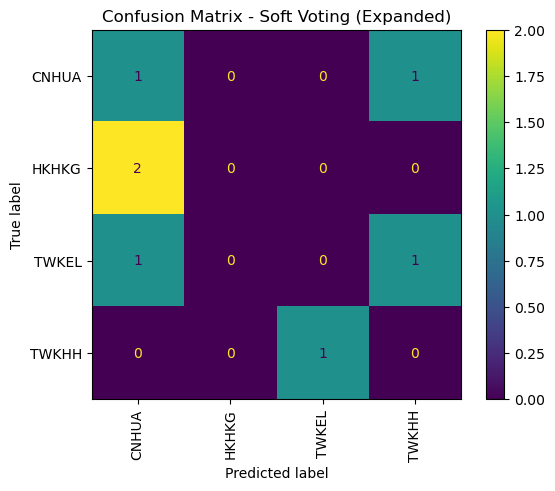

In [41]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, classification_report,
    ConfusionMatrixDisplay, make_scorer
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    classification_report,
    make_scorer,
    ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ===== 1. 데이터 불러오기 및 CLUSTER_1 == 4 필터링 =====
df = pd.read_csv('./dataset/must_use_final.csv')  # 직접 경로 수정 가능
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = df[df["CLUSTER_1"] == 4].copy()
df = df.sort_values("TIMESTAMP").reset_index(drop=True)

# ===== 2. 14시간 시점 기준 추출 (같은 선박이더라도 PORT_NAME 다르면 다르게) =====
time_based_data = []
max_gap = pd.Timedelta(minutes=10)
for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty:
        continue
    start_time = group["TIMESTAMP"].min()
    target_time = start_time + pd.Timedelta(hours=17)
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin()
    if time_diff[closest_idx] <= max_gap:
        time_based_data.append(group.loc[closest_idx])
df_14h = pd.DataFrame(time_based_data).reset_index(drop=True)

# ===== 3. 피처 및 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
df_14h = df_14h.dropna(subset=features + ["PORT_NAME"])
le = LabelEncoder()
df_14h["label"] = le.fit_transform(df_14h["PORT_NAME"])  # 숫자로 바꾼 종속변수

# ===== 6. 학습/테스트 분할 =====
X = df_14h[features]
y = df_14h["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===== 7. 오버샘플링 (train만) =====
train_df = pd.concat([X_train, y_train], axis=1)
oversampled_rows = []
target_size = int(train_df["label"].value_counts().max() * 1.5)

for label in train_df["label"].unique():
    subset = train_df[train_df["label"] == label]
    if len(subset) < target_size:
        upsampled = resample(subset, replace=True, n_samples=target_size, random_state=42)
        oversampled_rows.append(upsampled)
    else:
        oversampled_rows.append(subset)

resampled_train = pd.concat(oversampled_rows).reset_index(drop=True)
X_train_raw = resampled_train[features]
y_train = resampled_train["label"]

# ===== ✅ StandardScaler 적용 =====
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test)

# ===== 모델 + 그리드서치 설정 =====
param_grids = {
    'xgb': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        'params': {
            'max_depth': [3],
            'n_estimators': [50],
            'learning_rate': [0.05],
        }
    },
    'lr': {
        'model': LogisticRegression(max_iter=500),
        'params': {
            'C': [0.1, 1.0],
            'solver': ['liblinear'],
            'class_weight': ['balanced']
        }
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5],
            'weights': ['uniform']
        }
    },
    'svc': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.5, 1.0],
            'kernel': ['rbf']
        }
    },
    'lgbm': {
        'model': LGBMClassifier(),
        'params': {
            'n_estimators': [50],
            'max_depth': [3],
            'learning_rate': [0.05]
        }
    }
}

# ===== 각 모델별 GridSearch 수행 =====
best_models = {}
for name, cfg in param_grids.items():
    grid = GridSearchCV(cfg['model'], cfg['params'], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"✅ Best params for {name}: {grid.best_params_}")

# ===== Soft Voting Classifier 구성 =====
voting_clf = VotingClassifier(
    estimators=[(k, v) for k, v in best_models.items()],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

# ===== 예측 및 과적합 평가 =====
y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
gap = train_acc - test_acc
train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

# ===== 교차검증 (전체 데이터 기준) =====
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(voting_clf, X, y, cv=skf, scoring='accuracy')
cv_f1 = cross_val_score(voting_clf, X, y, cv=skf, scoring=make_scorer(f1_score, average='macro'))
cv_prec = cross_val_score(voting_clf, X, y, cv=skf, scoring=make_scorer(precision_score, average='macro'))

# ===== 결과 출력 =====
print("\n📊 [앙상블 성능 평가 및 과적합 진단]")
print(f"Train Accuracy           : {train_acc:.4f}")
print(f"Test Accuracy            : {test_acc:.4f}")
print(f"Accuracy Gap             : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '✅ 과적합 위험 없음'}")
print(f"Train F1-score (macro)   : {train_f1:.4f}")
print(f"Test F1-score (macro)    : {test_f1:.4f}")
print(f"CV Accuracy Mean         : {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
print(f"CV F1-score Mean         : {cv_f1.mean():.4f}")
print(f"CV Precision Mean        : {cv_prec.mean():.4f}")

# ===== 리포트 및 혼동행렬 =====
print("\n📄 [Classification Report]")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(voting_clf, X_test, y_test, display_labels=le.classes_, xticks_rotation=90)
plt.title("Confusion Matrix - Soft Voting (Expanded)")
plt.show()

In [49]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c4_17hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c4_17hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 6번 군집

라벨링 완료된 CLUSTER_1 == 6 데이터


,Unnamed: 0,COUNTRY,PORT_NAME,VSL_ID,TIMESTAMP,COG,HEADING,LAT,LON,PORT_CD,CLUSTER_1,CLUSTER_2,label
150110,157690,CN,CNLYG,615046a4-ea69-377a-b3a9-f9927165f9e4,2024-12-06 17:00:00,289.0,289.666667,34.652154,121.982664,CNLYG,6,1,1
150141,157721,CN,CNLYG,615046a4-ea69-377a-b3a9-f9927165f9e4,2024-12-06 22:10:00,282.1,281.000000,34.831208,120.710290,CNLYG,6,1,1
126424,134004,CN,CNTXG,7489e60a-7a4c-35fc-b57a-9c07f76fa1d2,2024-11-29 16:10:00,282.9,279.000000,38.666508,120.685758,CNTXG,6,4,4
64116,71696,CN,CNQDG,8bb32b1c-e699-3fe5-a503-29e2f45a060d,2024-10-14 18:20:00,283.2,282.000000,36.028257,120.323873,CNQDG,6,2,2
62621,70201,CN,CNQDG,37154f3b-a9d2-36b4-bcf2-e8b9fcea9d11,2024-11-02 23:00:00,294.8,301.000000,33.832230,125.375833,CNQDG,6,2,2
151142,158722,CN,CNDAG,c4a0ea1d-e999-3b21-b394-521a19c74c8b,2024-09-12 11:30:00,328.5,325.500000,35.752425,124.991667,CNDAG,6,0,0
151429,159009,CN,CNDAG,05e4d21a-31a0-3476-adf8-792558757ade,2024-12-13 22:20:00,255.4,260.000000,34.332340,127.946240,CNDAG,6,0,0
61814,69394,CN,CNQDG,485929b5-0963-33d9-ae84-d7d2ed8dd715,2024-10-31 02:40:00,79.4,182.000000,35.744225,120.955678,CNQDG,6,2,2
68252,75832,CN,CNQDG,cf8263b9-d3a1-386e-80c0-e74fb265f6d9,2024-12-13 14:10:00,25.0,341.000000,35.818283,120.987500,CNQDG,6,2,2
60480,68060,CN,CNQDG,1019badb-0b17-306b-a41f-ecef79dd1886,2024-10-26 15:40:00,320.5,54.000000,35.885647,120.966178,CNQDG,6,2,2


CLUSTER_2 종류: 5
📊 [Logistic Regression 성능]
              precision    recall  f1-score   support

       CNDAG       0.00      0.00      0.00         1
       CNLYG       0.25      0.25      0.25         4
       CNQDG       0.50      0.22      0.31         9
       CNRZH       0.00      0.00      0.00         1
       CNTXG       0.50      0.33      0.40         3

    accuracy                           0.22        18
   macro avg       0.25      0.16      0.19        18
weighted avg       0.39      0.22      0.28        18


📊 [XGBoost 성능]
              precision    recall  f1-score   support

       CNDAG       0.33      1.00      0.50         1
       CNLYG       0.50      0.25      0.33         4
       CNQDG       0.60      0.67      0.63         9
       CNRZH       0.00      0.00      0.00         1
       CNTXG       0.00      0.00      0.00         3

    accuracy                           0.44        18
   macro avg       0.29      0.38      0.29        18
weighted avg      

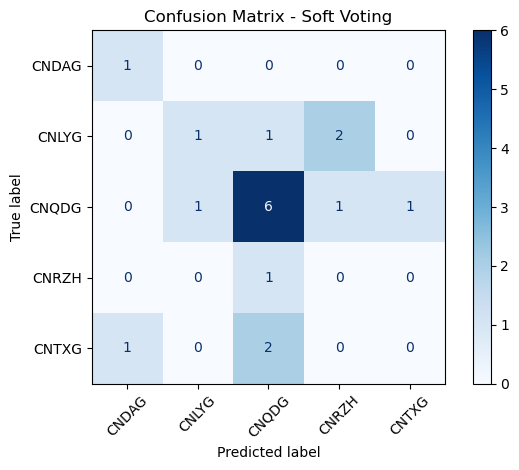

In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ===== 1. 데이터 불러오기 =====
df = pd.read_csv('./dataset/must_use_final.csv')
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
cluster_df = df[df['CLUSTER_1'] == 6].copy()

# ===== 2. 라벨 인코딩 =====
le = LabelEncoder()
cluster_df['label'] = le.fit_transform(cluster_df['PORT_NAME'])
print("라벨링 완료된 CLUSTER_1 == 6 데이터")
display(cluster_df.sample(10))
print(f"CLUSTER_2 종류: {cluster_df['label'].nunique()}")

# ===== 3. 17시간 시점 데이터 추출 =====
max_gap = pd.Timedelta(minutes=10)
hour = 17
time_based_data = []

for (vsl_id, port), group in cluster_df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty:
        continue
    start_time = group["TIMESTAMP"].min()
    target_time = start_time + pd.Timedelta(hours=hour)
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin()
    if time_diff[closest_idx] <= max_gap:
        closest_row = group.loc[closest_idx]
        time_based_data.append(closest_row)

df_5h = pd.DataFrame(time_based_data).reset_index(drop=True)

# ===== 4. 특징 및 라벨 설정 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["label"]  # 숫자형 라벨 사용

# ===== 5. 학습/테스트 분할 =====
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# ===== 6. 오버샘플링 (Train 데이터만) =====
train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
target = 'label'
min_target = 15
oversampled_rows = []

for label_value in train_df[target].unique():
    subset = train_df[train_df[target] == label_value]
    if len(subset) < min_target:
        upsampled = resample(subset, replace=True, n_samples=min_target, random_state=42)
        oversampled_rows.append(upsampled)
    else:
        oversampled_rows.append(subset)

train_oversampled = pd.concat(oversampled_rows).reset_index(drop=True)
X_train = train_oversampled[features]
y_train = train_oversampled[target]

# ===== 7. 저장 =====
np.save("datasets/X_train_c6_17hours.npy", X_train)
np.save("datasets/X_test_c6_17hours.npy", X_test)
np.save("datasets/y_train_c6_17hours.npy", y_train)
np.save("datasets/y_test_c6_17hours.npy", y_test)

# ===== 8. 모델 정의 및 학습 =====
# Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# XGBoost
xgb_model = XGBClassifier(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# ===== 9. 평가 (단일 모델) =====
print("📊 [Logistic Regression 성능]")
print(classification_report(y_test, lr_pred, target_names=le.classes_))

print("\n📊 [XGBoost 성능]")
print(classification_report(y_test, xgb_pred, target_names=le.classes_))

# ===== 10. Soft Voting 앙상블 정의 및 평가 =====
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)

print("\n📊 [Soft Voting 앙상블 성능]")
print(classification_report(y_test, voting_pred, target_names=le.classes_))

acc = accuracy_score(y_test, voting_pred)
print(f"✅ Accuracy: {acc:.4f}")

# ===== 11. 혼동 행렬 시각화 =====
cm = confusion_matrix(y_test, voting_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Soft Voting")
plt.tight_layout()
plt.show()


In [86]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c6_17hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c6_17hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 7번 군집

라벨링 완료된 CLUSTER_1 == 7 데이터


,Unnamed: 0,COUNTRY,PORT_NAME,VSL_ID,TIMESTAMP,COG,HEADING,LAT,LON,PORT_CD,CLUSTER_1,CLUSTER_2,label
9647,9647,RU,RUVVO,ce91982b-2a11-3f4a-8e5a-738756ab5658,2024-12-06 04:00:00,352.450000,347.00,38.573823,128.720172,RUVVO,7,1,1
9134,9134,RU,RUVVO,1efac1d5-4f2a-3fef-917e-a9f480f0853b,2024-07-20 03:50:00,325.300000,326.00,42.874438,132.168500,RUVVO,7,1,1
5846,5846,RU,RUVVO,59b78c36-ce29-3266-813a-85976eeee38d,2024-11-16 19:20:00,312.022222,314.00,41.777269,133.268237,RUVVO,7,1,1
47047,54627,RU,RUNJK,36b7f548-66e0-3968-a81f-f8a9fde3e9b7,2024-09-06 10:50:00,227.000000,340.00,42.806333,132.966000,RUNJK,7,0,0
45815,53395,RU,RUNJK,8d2dbfb5-3d23-3e10-86cb-0309e36d6115,2024-11-29 22:00:00,286.800000,321.00,42.815425,132.957840,RUNJK,7,0,0
45540,53120,RU,RUNJK,8d2dbfb5-3d23-3e10-86cb-0309e36d6115,2024-11-28 00:10:00,352.675000,111.75,42.266311,132.993744,RUNJK,7,0,0
46944,54524,RU,RUNJK,36b7f548-66e0-3968-a81f-f8a9fde3e9b7,2024-09-05 17:40:00,321.000000,345.00,42.806167,132.965167,RUNJK,7,0,0
9194,9194,RU,RUVVO,c3164adf-3972-39fd-86a7-ff7420cfc95f,2024-10-18 04:40:00,40.000000,221.00,36.311667,130.636667,RUVVO,7,1,1
11870,11870,RU,RUVVO,8927b963-cf8f-3b7d-92e6-c986926fd80b,2024-08-25 00:10:00,0.500000,2.00,42.340267,131.649583,RUVVO,7,1,1
45496,53076,RU,RUNJK,8d2dbfb5-3d23-3e10-86cb-0309e36d6115,2024-11-27 16:50:00,35.500000,33.00,41.184167,132.107500,RUNJK,7,0,0


CLUSTER_2 종류: 2


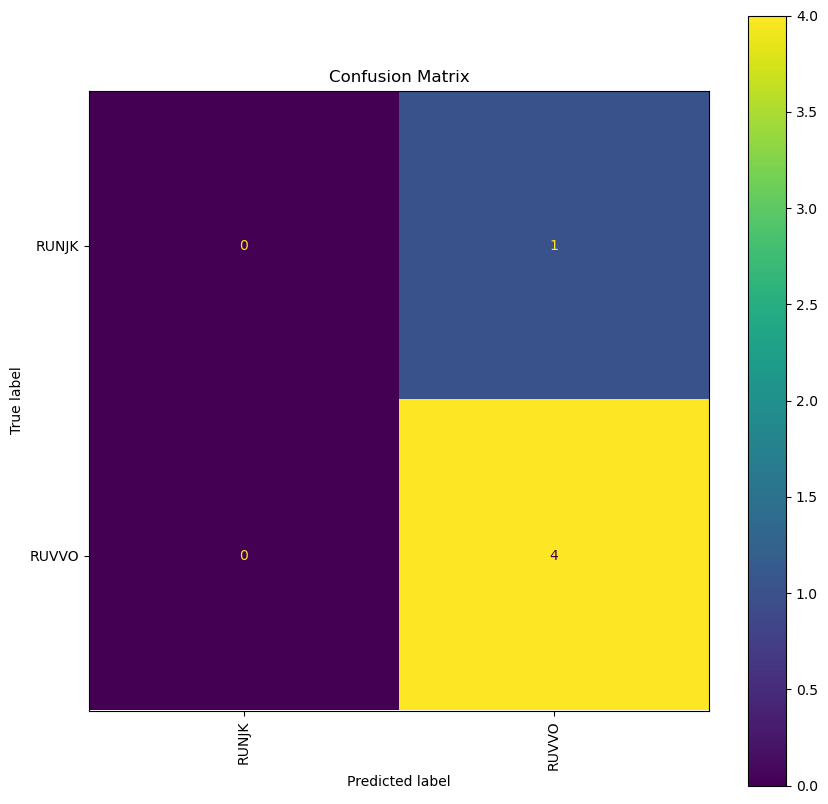

📊 [교차검증 결과]
Accuracy (Train): 1.0000
Accuracy (Test): 0.8000
CV Accuracy Mean: 0.9714 ± 0.0571
CV F1 Macro: 0.9689
CV Precision Macro: 0.9800
⚠️ 과적합 의심: 학습/테스트 정확도 차이 0.2000

📄 [Classification Report]
              precision    recall  f1-score   support

       RUNJK       0.00      0.00      0.00         1
       RUVVO       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.utils import resample
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ===== 1. 데이터 불러오기 =====
df = pd.read_csv('./dataset/must_use_final.csv')
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
cluster_df = df[df['CLUSTER_1'] == 7].copy()

# ===== 2. 라벨 인코딩 =====
le = LabelEncoder()
cluster_df['label'] = le.fit_transform(cluster_df['PORT_NAME'])
print("라벨링 완료된 CLUSTER_1 == 7 데이터")
display(cluster_df.sample(10))
print(f"CLUSTER_2 종류: {cluster_df['label'].nunique()}")

# ===== 3. 17시간 시점 데이터 추출 =====
max_gap = pd.Timedelta(minutes=10)
hour = 17
time_based_data = []

for (vsl_id, port), group in cluster_df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty:
        continue
    start_time = group["TIMESTAMP"].min()
    target_time = start_time + pd.Timedelta(hours=hour)
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin()
    if time_diff[closest_idx] <= max_gap:
        time_based_data.append(group.loc[closest_idx])

df_5h = pd.DataFrame(time_based_data).reset_index(drop=True)

# ===== 4. 특징 및 라벨 설정 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["label"]

# ===== 5. 학습/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===== 6. 오버샘플링 (train만) =====
df_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
max_count = df_train["label"].value_counts().max()
resampled = []

for label in df_train["label"].unique():
    subset = df_train[df_train["label"] == label]
    upsampled = resample(subset, replace=True, n_samples=max_count, random_state=42)
    resampled.append(upsampled)

df_balanced = pd.concat(resampled)
X_train_bal = df_balanced[features]
y_train_bal = df_balanced["label"]

# ===== 7. 저장 =====
np.save("datasets/X_train_c7_17hours.npy", X_train_bal)
np.save("datasets/X_test_c7_17hours.npy", X_test)
np.save("datasets/y_train_c7_17hours.npy", y_train_bal)
np.save("datasets/y_test_c7_17hours.npy", y_test)

# ===== 8. 모델 정의 =====
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=14,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=120,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.1,
    scale_pos_weight=1.3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft'
)

# ===== 9. 학습 =====
voting_clf.fit(X_train_bal, y_train_bal)

# ===== 10. 평가 =====
y_pred = voting_clf.predict(X_test)

# 교차검증
acc_scores = cross_val_score(voting_clf, X_train_bal, y_train_bal, cv=5, scoring='accuracy')
f1_scores = cross_val_score(voting_clf, X_train_bal, y_train_bal, cv=5, scoring='f1_macro')
prec_scores = cross_val_score(voting_clf, X_train_bal, y_train_bal, cv=5, scoring='precision_macro')

# 정확도 비교
train_score = voting_clf.score(X_train_bal, y_train_bal)
test_score = voting_clf.score(X_test, y_test)
gap = train_score - test_score

# 리포트 및 혼동행렬
target_names = le.inverse_transform(sorted(y.unique()))
report = classification_report(y_test, y_pred, target_names=target_names.astype(str))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ===== 11. 결과 출력 =====
print("📊 [교차검증 결과]")
print(f"Accuracy (Train): {train_score:.4f}")
print(f"Accuracy (Test): {test_score:.4f}")
print(f"CV Accuracy Mean: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"CV F1 Macro: {f1_scores.mean():.4f}")
print(f"CV Precision Macro: {prec_scores.mean():.4f}")
if gap > 0.1:
    print(f"⚠️ 과적합 의심: 학습/테스트 정확도 차이 {gap:.4f}")
else:
    print("✅ 과적합 위험 없음")

print("\n📄 [Classification Report]")
print(report)


In [80]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c7_17hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c7_17hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.
